In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Trip Start and end Dates: Dec 10, 2021 - Dec 23, 2021


# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.sql import func
from sqlalchemy import create_engine,  inspect

In [5]:
# Create the connection engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc()).first()

first_date = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.asc()).first()

last_date_formated = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
first_date_formated = dt.datetime.strptime(first_date[0], '%Y-%m-%d')


# Calculate the date 1 year ago(365 days) from the last data point in the database
one_year_before_latest = last_date_formated - dt.timedelta(days=365)



print(f'The dates being analyzed are in the range of {one_year_before_latest} and {last_date_formated}')

# Perform a query to retrieve the data and precipitation scores
targeted_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(one_year_before_latest, last_date_formated))

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(targeted_year_data, columns=['date','prcp'])

#cleaning out all na's
precipitation_df = precipitation_df.dropna(how='any')

# converting date column to datetime
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# Sort the dataframe by date
precipitation_df.sort_values('date')

last_date_formated

The dates being analyzed are in the range of 2016-08-23 00:00:00 and 2017-08-23 00:00:00


datetime.datetime(2017, 8, 23, 0, 0)

Text(0.5, 0, 'Dates')

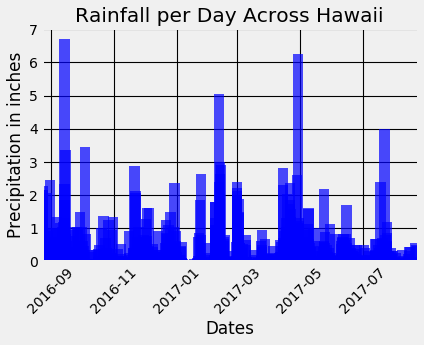

In [11]:

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax  = plt.subplots()


ax.set_xlim([one_year_before_latest,last_date_formated ])
plt.bar(precipitation_df["date"], precipitation_df["prcp"], width=10, color="blue", alpha=.70)
ax.tick_params(axis='x', labelrotation = 45)
ax.grid(color='black', linestyle='-', linewidth=1.1)



#labels
ax.set_title('Rainfall per Day Across Hawaii')
ax.set_ylabel('Precipitation in inches')
ax.set_xlabel('Dates')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_of_stations_query = session.query(Measurement.station).distinct().count()
num_of_stations_query

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data_points = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_data_points

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_station_data_points = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()

most_station_data_points

(54.0, 85.0, 71.66378066378067)

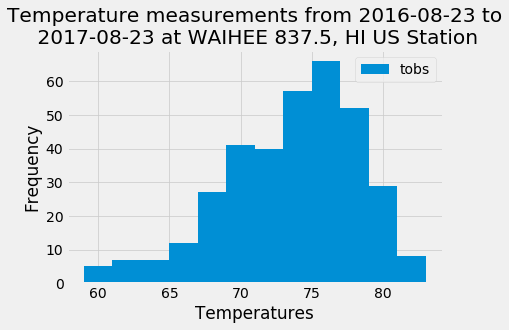

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
chosen_station_measurements = session.query(Measurement.tobs).\
    filter(Measurement.station == station_data_points[0][0]).\
    filter(Measurement.date >= one_year_before_latest).all()

# list of temps from query above
temperatures = list(np.ravel(chosen_station_measurements))
temperatures


# variable for all station info
station_query = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation)
# creating df for the info above
station_info = pd.DataFrame(station_query, columns=['station','name','latitude','longitude','elevation'])
# find stations where name = max measurements and returns station name in list
selected_station_name = station_info.loc[station_info['station'] == station_data_points[0][0], "name"].tolist()



# Data conversions to prevent issues with remove time in title
beginning_date = pd.to_datetime(one_year_before_latest).date()
ending_date = pd.to_datetime(last_date_formated).date()



plt.hist(temperatures, bins=12,rwidth=1.1,label='tobs',alpha=1)
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperatures')
plt.title(f"Temperature measurements from {beginning_date} to\n {ending_date} at {selected_station_name[0]} Station")
plt.legend()


## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
